# Sentiment Analysis on Amazon Alexa Reviews using DistilBERT
 (a distilled version of BERT: smaller,
faster, cheaper and lighter)


## 1. Import necessary libraries

In [1]:
# To load, visualize and preprocess data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00


In [49]:
# To use Hugging Face Transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# To support NN models 
import tensorflow as tf
tf.autograph.set_verbosity(0)
from keras import activations, optimizers, losses 
from tensorflow.keras.callbacks import EarlyStopping

# To save model
import pickle 

# To ignore warnings
import warnings
warnings.simplefilter('ignore')

## 2. Load Amazon Alexa Reviews Data

In [7]:
file_path = './amazon_alexa.tsv'
df_rawdata = pd.read_csv(file_path, delimiter = '\t') # read tsv file
df_rawdata.head() # display sample data

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [8]:
df_rawdata.shape 

(3150, 5)

## 3. Explore Data

In [9]:
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [10]:
df_rawdata['feedback'].unique()

array([1, 0])

In [11]:
df_rawdata['feedback'].value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [12]:
df_rawdata[df_rawdata['feedback'] == 1]['verified_reviews'].head() # postive reviews

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [13]:
df_rawdata[df_rawdata['feedback'] == 0]['verified_reviews'].head() # negative reviews

46     It's like Siri, in fact, Siri answers more acc...
111    Sound is terrible if u want good music too get...
141                                   Not much features.
162    Stopped working after 2 weeks ,didn't follow c...
176                                 Sad joke. Worthless.
Name: verified_reviews, dtype: object

### Sampling Dataset
To avoid target variable bias in the data, it is important to ensure a balanced representation of each target variable. One approach you can take is to randomly select 250 records for each target variable from your dataset.

In [14]:
# Filter 250 positive reviews 
df_positive = df_rawdata[df_rawdata['feedback'] == 1].sample(250)
df_positive.shape[0]

250

In [15]:
# Filter 250 negative reviews 
df_negative = df_rawdata[df_rawdata['feedback'] == 0].sample(250)
df_negative.shape[0]

250

In [16]:
# combine both datasets
df_balanced = pd.concat([df_positive,df_negative],axis=0).reset_index()
df_balanced

,index,rating,date,variation,verified_reviews,feedback
0,2789,4,30-Jul-18,White Dot,Barry,1
1,640,5,28-May-18,Black,Love it,1
2,632,5,30-May-18,White,Great little thing. Works better than siri.,1
3,957,5,29-Jul-18,Sandstone Fabric,Arrived as expected.,1
4,2844,4,30-Jul-18,Black Dot,I've only got to use it for a couple of weeks ...,1
...,...,...,...,...,...,...
495,1386,1,17-Jul-18,Black Spot,Invasive and scared the crap out of me for spe...,0
496,531,1,19-Jun-18,Black,This is the worst Amazon purchase I have made....,0
497,2309,1,30-Jul-18,Configuration: Fire TV Stick,The Firestick we were sent doesn’t work. At al...,0
498,406,1,16-Jul-18,White,,0


In [17]:
df_balanced['feedback'].value_counts()

1    250
0    250
Name: feedback, dtype: int64

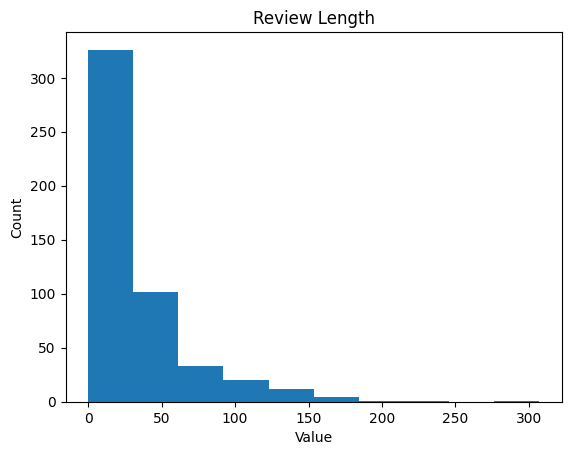

In [18]:
# check lengths of verified_reviews
df_balanced['review_length'] = df_balanced['verified_reviews'].apply(lambda x: len(x.split()))

# display histogram with counts of review lengths
x = np.array(df_balanced['review_length'])
plt.hist(x)
plt.title('Review Length')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show() 

## 4. Pre-processing data

In [19]:
# Convert dataframe series object into list to provide input to DistilBERT model
X = df_balanced['verified_reviews'].to_list()
y = df_balanced['feedback'].to_list()

In [20]:
# Define encoding function using DistilBERT tokenizer to preprocess the text field
  #  truncate text if its length is > max_length
  #  reviews with less than max_length are padded with 0s
def perform_encoding(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding);
 
# Call encoding function by assigning paramters
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 100
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME)
encodings = perform_encoding(X, tokenizer=TOKENIZER, max_len=MAX_LENGTH)

In [21]:
# Define a function for converting encodings and y (target variable) into a Tensorflow object
def create_tfdataset(encodings, y=None):
    if y:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # used to make predictions after training on unseen samples 
        return tf.data.Dataset.from_tensor_slices(dict(encodings))

tf_dataset = create_tfdataset(encodings, y)

## 5. Prepare Train, Validation and Test datasets

In [22]:
# define the sizes for train, validation, and test sets
total_samples = len(y)
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.15 * total_samples)  # 15% for validation
test_size = total_samples - train_size - val_size  # Remaining for testing

# Shuffle the dataset
dataset = tf_dataset.shuffle(buffer_size=total_samples, seed=42)

# Split the dataset into train, validation, and test sets
train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

print(f'Train dataset size: {len(list(train_dataset))}')
print(f'Validation dataset size: {len(list(val_dataset))}')
print(f'Test dataset size: {len(list(test_dataset))}')

Train dataset size: 350
Validation dataset size: 75
Test dataset size: 75


In [23]:
# create batches of the data, each batch having number of samples equal to the batch size
BATCH_SIZE = 32
tfdataset_train = train_dataset.batch(BATCH_SIZE)
tfdataset_val = val_dataset.batch(BATCH_SIZE)
tfdataset_test = test_dataset.batch(BATCH_SIZE)

print('Number of batches of Training data: ',len(tfdataset_train))
print('Number of batches of Testing data: ',len(tfdataset_test))
print('Number of batches of Validation data: ',len(tfdataset_val))

Number of batches of Training data:  11
Number of batches of Testing data:  3
Number of batches of Validation data:  3


## 6. Train Model

In [24]:
# Define required training hyperparameters and arguments

N_EPOCHS = 10
MODEL_NAME = 'distilbert-base-uncased'

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # Here we have 2 classes (1: Positive, 0:Negative)
optimizer = optimizers.Adam(learning_rate=3e-5) # Learning rate hyper-parameter
loss = losses.SparseCategoricalCrossentropy(from_logits=True) # SparseCategoricalCrossentropy is used as our target class is integer encoded

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [25]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [26]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,validation_data=tfdataset_val,verbose=1, callbacks=[early_stopping])

Epoch 1/10
11/11 [==============================] - 16s 469ms/step - loss: 0.6670 - accuracy: 0.6171 - val_loss: 0.5751 - val_accuracy: 0.8533
Epoch 2/10
11/11 [==============================] - 4s 322ms/step - loss: 0.4827 - accuracy: 0.8171 - val_loss: 0.3395 - val_accuracy: 0.8667
Epoch 3/10
11/11 [==============================] - 4s 326ms/step - loss: 0.2614 - accuracy: 0.9029 - val_loss: 0.2042 - val_accuracy: 0.9200
Epoch 4/10
11/11 [==============================] - 4s 326ms/step - loss: 0.1490 - accuracy: 0.9600 - val_loss: 0.1429 - val_accuracy: 0.9600
Epoch 5/10
11/11 [==============================] - 4s 328ms/step - loss: 0.1217 - accuracy: 0.9600 - val_loss: 0.0905 - val_accuracy: 0.9733
Epoch 6/10
11/11 [==============================] - 4s 329ms/step - loss: 0.0906 - accuracy: 0.9743 - val_loss: 0.0715 - val_accuracy: 0.9867
Epoch 7/10
11/11 [==============================] - 4s 336ms/step - loss: 0.0485 - accuracy: 0.9857 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch

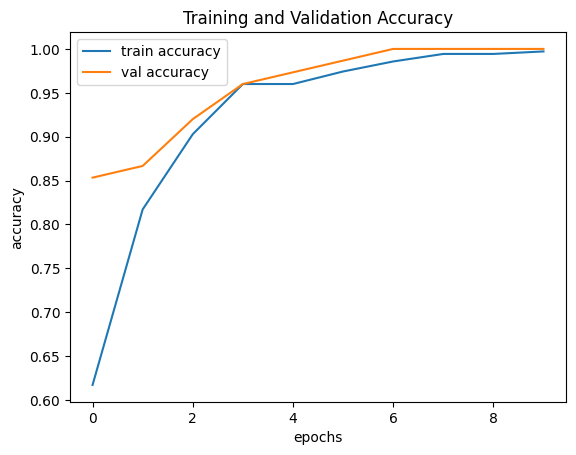

In [28]:
# Accuracy vs Epochs graph

epochs = list(range(10))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy') 
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

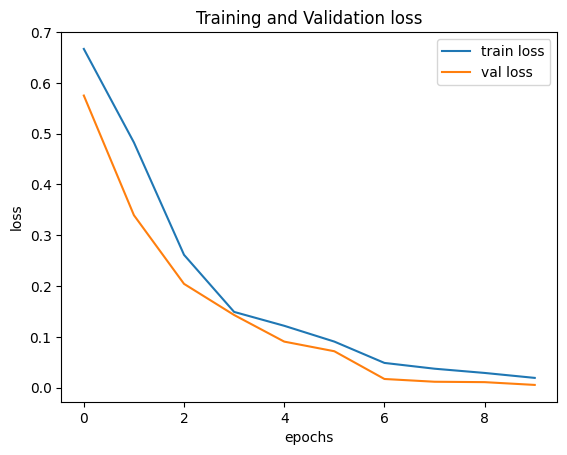

In [29]:
# Loss vs Epochs graph
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 7. Test Model

In [30]:
# Test model performance on unseed data
benchmarks = model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE,verbose=1)
print(benchmarks)

3/3 [==============================] - 0s 101ms/step - loss: 0.0553 - accuracy: 0.9867
{'loss': 0.05525965243577957, 'accuracy': 0.9866666793823242}


## 8. Predict Using Fine-Tuned Model

In [40]:
def create_prediction(model, model_name, max_len):
  tokenizer = DistilBertTokenizer.from_pretrained(model_name)
  def predict_prob(text):
      x = [text]
      encodings = perform_encoding(x, tokenizer, max_len=max_len)
      tfdataset = create_tfdataset(encodings)
      tfdataset = tfdataset.batch(1)
      preds = model.predict(tfdataset).logits
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][1]
  return predict_prob

def predict_review_type(predicted_probability):
  if predicted_probability >= 0.75:
      y_pred = 'Positive 😁'
  elif 0.25 <= predicted_probability < 0.75:
      y_pred = 'Neutral 😐'
  else:
      y_pred = 'Negative 😞'
  return y_pred

MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 100
INPUT_TEXT = "This was a masterpiece, I'm enjoying it!"
clf = create_prediction(model, MODEL_NAME, MAX_LENGTH)
print(INPUT_TEXT)
prob = clf(INPUT_TEXT)
print(predict_review_type(prob))

This was a masterpiece, I'm enjoying it!
1/1 [==============================] - 0s 55ms/step
Positive 😁


## 9. Save Model

In [43]:
# save model locally or drive
model.save_pretrained('./SA_BERT_model/clf1')
with open('./SA_BERT_model/info1.pkl', 'wb') as f:
    pickle.dump((MODEL_NAME, MAX_LENGTH), f)
print('Saved model in Specified path!')

/content/drive/MyDrive/Github/NLP_Projects/SentimentAnalysis_DistilBert
Saved model in Specified path!


## 10. Load the model in Future

In [48]:
new_model = TFDistilBertForSequenceClassification.from_pretrained('./SA_BERT_model/clf1')
model_name, max_len = pickle.load(open('./SA_BERT_model/info1.pkl', 'rb'))

ls_text_input = [
    "Alexa is very useful and answers correctly to my questions however it doesn't get connected well to my laptop's bluetooth"
    , "Gets disconnecetd again and again, I'll not recommend it to others"
    , "Love my Echo!"
]
for text in ls_text_input:
  clf = create_prediction(new_model, model_name, max_len)
  print(text)
  prob = clf(text)
  print(predict_review_type(prob))

Some layers from the model checkpoint at ./SA_BERT_model/clf1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./SA_BERT_model/clf1 and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Alexa is very useful and answers correctly to my questions however it doesn't get connected well to my laptop's bluetooth
1/1 [==============================] - 2s 2s/step
Positive 😁
Gets disconnecetd again and again, I'll not recommend it to others
1/1 [==============================] - 3s 3s/step
Negative 😞
Love my Echo!
1/1 [==============================] - 0s 19ms/step
Positive 😁


# References:
1. DistilBERT: https://arxiv.org/abs/1910.01108 (a general-purpose pre-trained version of BERT, 40% smaller, 60% faster, that retains 97% of the language understanding capabilities)
2. HuggingFace🤗Transformers for Text Classification: https://huggingface.co/docs/transformers/tasks/sequence_classification
3. Dataset for Sentiment Analysis: https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews


Application: NLP -> Text Classification -> Sentiment Analysis